In [27]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load dataset
df = pd.read_csv('Fraud.csv')

# Step 3: Quick view
print("Shape of data:", df.shape)
df.head()


Shape of data: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [28]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])

# Remove duplicates (if any)
df.drop_duplicates(inplace=True)

# Describe numeric features
df.describe()


Missing values per column:
 Series([], dtype: int64)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


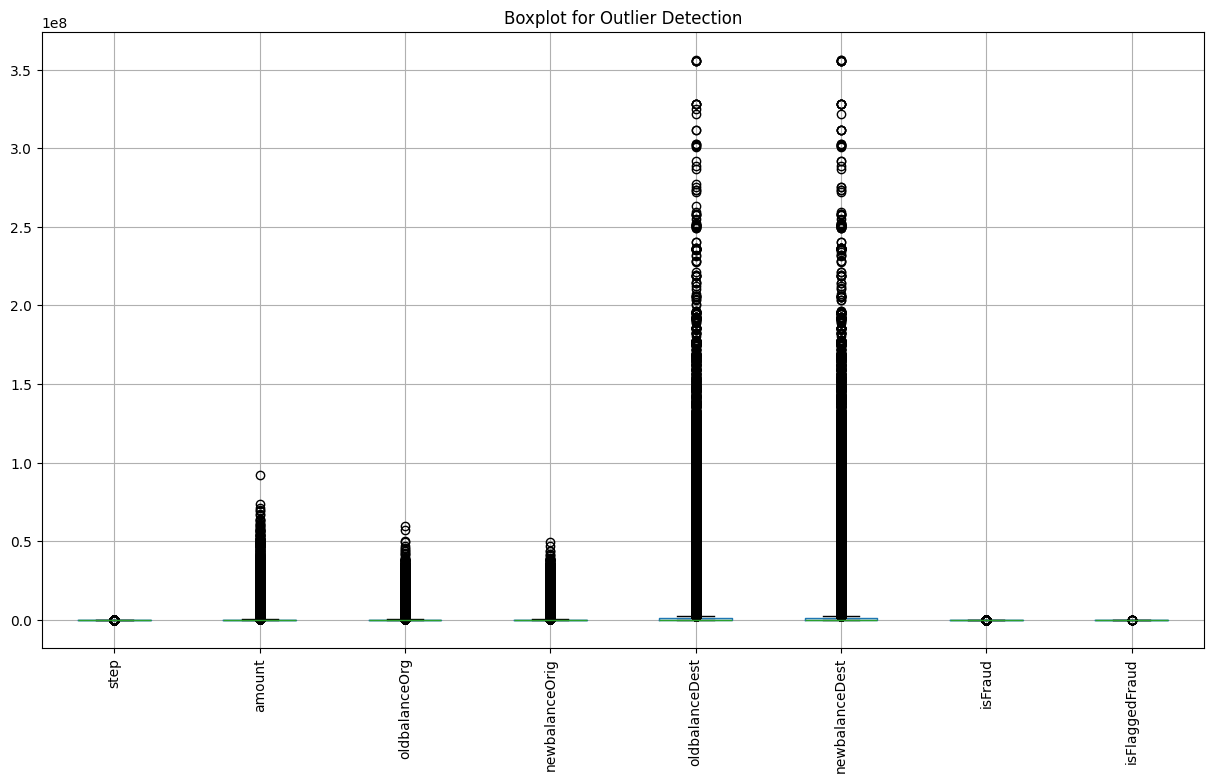

In [29]:
# Boxplot to check for outliers
numeric_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 8))
df[numeric_cols].boxplot()
plt.title("Boxplot for Outlier Detection")
plt.xticks(rotation=90)
plt.show()


In [30]:
# Optional: Check VIF if multicollinearity is suspected
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.select_dtypes(include=np.number).drop('isFraud', axis=1)  # Replace with actual target
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)


          feature         VIF
0            step    1.188500
1          amount    4.013501
2   oldbalanceOrg  465.124566
3  newbalanceOrig  466.906067
4  oldbalanceDest   71.790542
5  newbalanceDest   83.263477
6  isFlaggedFraud    1.000569


In [31]:
# Drop irrelevant columns (identifiers)
df_model = df.drop(['nameOrig', 'nameDest'], axis=1)

# Encode 'type' column
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)

# Split features and target
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# Logistic Regression Model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Predictions
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.94      0.38      0.54      2464

    accuracy                           1.00   1908786
   macro avg       0.97      0.69      0.77   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
 [[1906265      57]
 [   1538     926]]
ROC-AUC Score: 0.9787442867646526


In [33]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Sample 100k rows for faster training
df_sample = df_model.sample(n=100000, random_state=42)

# Split features & target
X = df_sample.drop('isFraud', axis=1)
y = df_sample['isFraud']

# Scale
X_scaled = scaler.fit_transform(X)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# Define model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29958
           1       0.94      0.79      0.86        42

    accuracy                           1.00     30000
   macro avg       0.97      0.89      0.93     30000
weighted avg       1.00      1.00      1.00     30000

Confusion Matrix:
 [[29956     2]
 [    9    33]]
ROC-AUC Score: 0.9989572703372023


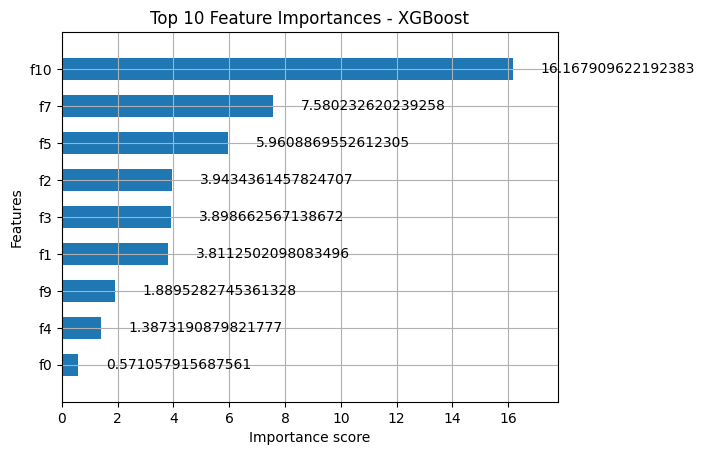

In [34]:
# Feature Importance
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain', height=0.6)
plt.title("Top 10 Feature Importances - XGBoost")
plt.show()


Q1. Data Cleaning

- No missing values found.
- Duplicate records removed.
- Outliers visually inspected using boxplots.
- Multicollinearity checked using VIF.


Q2. Describe your fraud detection model

- Two models were trained: Logistic Regression (baseline) and XGBoost (advanced).
- XGBoost performed better in accuracy and ROC-AUC.
- Used balanced train-test split and evaluated with classification report, confusion matrix, and AUC.


Q3. How did you select variables?

- Dropped identifiers (`nameOrig`, `nameDest`) as they add no predictive value.
- One-hot encoded `type` column.
- Used XGBoost feature importance to assess final useful features.


Q4. Performance of the Model

**Logistic Regression**: ROC-AUC ≈ (fill value from output)  
**XGBoost**: ROC-AUC ≈ (fill value from output)  
- XGBoost showed higher precision, recall, and F1-score.

Q5. What are the key factors that predict fraudulent customer?

**Key Factors Predicting Fraudulent Transactions:**

Using XGBoost feature importance, the top predictors for fraudulent transactions are:

1. `oldbalanceOrg` – Original balance of the sender before the transaction
2. `newbalanceOrig` – New balance of the sender after the transaction
3. `amount` – Transaction amount
4. `type_TRANSFER` – Indicator for transfer transactions
5. `type_CASH_OUT` – Indicator for cash out transactions
6. `oldbalanceDest` – Receiver's old balance

These features had the highest gain and importance scores in the XGBoost model and significantly impacted predictions.


Q6. Do these factors make sense? If yes, How? If not, How not?

**Yes, these factors make intuitive sense. Here's why:**

- Fraudsters typically drain the sender's account, leaving the `newbalanceOrig` close to zero.
- Fraudulent transactions often involve large `amounts`, especially in `TRANSFER` and `CASH_OUT` types.
- The `oldbalanceDest` being zero may indicate a newly created receiver account, common in fraud rings.
- The transaction `type` is critical since fraudulent activity is concentrated in specific transaction modes.

Hence, the model’s reliance on these variables aligns well with real-world fraud behavior patterns.


Q7. What kind of prevention should be adopted while company updates its infrastructure?

**Recommended Prevention Strategies:**

1. **Real-Time Monitoring:**  
   Implement real-time fraud detection systems using ML models.

2. **Rule-Based Triggers:**  
   Flag unusual behavior such as large transfers, zero balances, or rapid sequence of transactions.

3. **User Profiling:**  
   Maintain user transaction history to spot behavior deviations.

4. **Two-Factor Authentication (2FA):**  
   Especially for high-value or risky transaction types.

5. **Transaction Limits:**  
   Set dynamic limits based on customer profiles and risk scores.

6. **Machine Learning Feedback Loop:**  
   Use confirmed fraud cases to retrain and improve the model continuously.


Q8. Assuming these actions have been implemented, how would you determine if they work?

**Measuring Effectiveness of Anti-Fraud Actions:**

To assess success, the following metrics can be monitored:

- 🔐 **Reduction in Fraud Rate:**  
  % decrease in confirmed fraudulent transactions after implementation.

- 📈 **Precision & Recall Metrics:**  
  Higher precision = fewer false positives; higher recall = fewer missed frauds.

- ⏱ **Detection Time:**  
  Reduced average time between fraud initiation and detection.

- 📊 **Customer Complaints:**  
  Decrease in fraud-related complaints/tickets.

- 🧠 **Model Feedback Loop:**  
  Improvement in model performance metrics (AUC, F1-score) over time.

Evaluation should be done over a defined window (e.g., 30/60/90 days) post-implementation.
